# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Import Data

In [2]:

features = np.load('clean_data/features.npy')
labels = np.load('clean_data/labels.npy')
features.shape,labels.shape

((55325, 33), (55325,))

## Spilt Train, Cross Validation and Test Data

In [3]:
x_train, x_test_full, y_train, y_test_full = train_test_split(features, labels, train_size=0.6, random_state=1)
x_test, x_cv, y_test, y_cv = train_test_split(x_test_full, y_test_full, train_size=0.5, random_state=1)
print(x_train.shape)
print(x_cv.shape)
print(x_test.shape)
print(y_train.shape)

(33195, 33)
(11065, 33)
(11065, 33)
(33195,)


# Back Propogation, R  Back Propogation

# Activation Function

In [4]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))
def relu(x):
    return np.maximum(0, x)
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# Function to initialize weights as Gaussian distributions with specific mu and sigma

In [5]:
def initialize_weights(nodes_in, nodes_out, mu=0.001, sigma=0.1):
    return np.random.normal(mu, sigma, size=(nodes_in, nodes_out))

## Neural Network

In [6]:
class NeuralNetwork:
    def __init__(self, x, y,vocabulary_size=21361, nodes_in_layer1=32, nodes_in_layer2=16, nodes_in_layer3=1, l_rate=1):
        embedding_dim = 50
        self.x = x
        vocab_size = vocabulary_size + 1  # Add 1 for the out-of-vocabulary token
        self.embedding_weights = np.random.randn(vocab_size, embedding_dim)
        self.inputs_in_layer0 = self.embedding(self.x)
        self.y = y.reshape(-1, 1)  # reshape y to be a column vector

        self.l_rate = l_rate  # learning rate

        self.nodes_in_layer1 = nodes_in_layer1
        self.nodes_in_layer2 = nodes_in_layer2
        self.nodes_in_layer3 = nodes_in_layer3

        self.thetas_layer0 = np.random.randn(self.inputs_in_layer0.shape[1] + 1, self.nodes_in_layer1) * np.sqrt(2 / (self.inputs_in_layer0.shape[1] + 1))
        self.thetas_layer1 = np.random.randn(self.nodes_in_layer1 + 1, self.nodes_in_layer2) * np.sqrt(2 / (self.nodes_in_layer1 + 1))
        self.thetas_layer2 = np.random.randn(self.nodes_in_layer2 + 1, self.nodes_in_layer3) * np.sqrt(2 / (self.nodes_in_layer2 + 1))

        self.epsilon = 1e-5
        self.momentum = 1
        self.gamma1 = np.ones(nodes_in_layer1)
        self.beta1 = np.zeros(nodes_in_layer1)
        self.gamma2 = np.ones(nodes_in_layer2)
        self.beta2 = np.zeros(nodes_in_layer2)


    def batch_normalize(self, input_data, gamma, beta):
        batch_mean = np.mean(input_data, axis=0)
        batch_var = np.var(input_data, axis=0)
        normalized_data = (input_data - batch_mean) / np.sqrt(batch_var + self.epsilon)
        scaled_and_shifted_data = gamma * normalized_data + beta
        return scaled_and_shifted_data

    def feedforward(self,x):
        self.inputs_in_layer0=x
        self.n = self.inputs_in_layer0.shape[0]
        self.Z1 = self.thetas_layer0[0] + np.dot(self.inputs_in_layer0, self.thetas_layer0[1:])
        self.layer1 = relu(self.Z1)
        self.normalized_data_layer1 = self.batch_normalize(self.layer1, self.gamma1, self.beta1)

        self.Z2 = self.thetas_layer1[0] + np.dot(self.normalized_data_layer1, self.thetas_layer1[1:])
        self.layer2 = relu(self.Z2)
        self.normalized_data_layer2 = self.batch_normalize(self.layer2, self.gamma2, self.beta2)

        self.Z3 = self.thetas_layer2[0] + np.dot(self.normalized_data_layer2, self.thetas_layer2[1:])
        self.layer3 = sigmoid(self.Z3)

        return self.layer3

    def cost_func(self,predict,y):
        y_pred=predict
        y_true=y
        epsilon = 1e-15  # small constant to avoid log(0)
            
        # Clip predicted probabilities to avoid log(0) and log(1)
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

        self.cost = - np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
            
        return self.cost
    def embedding(self, x):
        self.embedded_input = self.embedding_weights[x]
        pooled_embeddings = np.mean(self.embedded_input, axis=1)
        return pooled_embeddings
    def calculate_accuracy(self,y,predict):
        actual_output=y
        predicted_output=predict

        predicted_classes = (predicted_output >= 0.5 ).astype(int)

        correct_predictions = (predicted_classes == actual_output).sum()

        accuracy = correct_predictions / len(actual_output)
        return accuracy

    def Rbackprop(self,predict,y):
        # Define RProp parameters
        delta0 = 0.001  # Initial update value
        delta_max = 60  # Maximum update value
        delta_min = 1e-6  # Minimum update value
        eta_plus = 1.5  # Increase factor
        eta_minus = 0.5  # Decrease factor
        epsilon = 1e-15
        self.layer3=predict
        self.y=y
        self.dE_dlayer3 = (1/self.n) * (self.layer3-self.y)/(self.layer3*(1-self.layer3)+epsilon)
        self.dE_dZ3 = np.multiply(self.dE_dlayer3, (sigmoid(self.Z3)* (1-sigmoid(self.Z3))))
        self.dE_dtheta2 = np.dot(self.layer2.T, self.dE_dZ3)
        self.dE_dbias2 = np.dot(np.ones(self.n), self.dE_dZ3)

        self.dE_dlayer2 = np.dot(self.dE_dZ3, self.thetas_layer2[1:].T)
        self.dE_dZ2 = np.multiply(self.dE_dlayer2, relu_derivative(self.Z2))
        self.dE_dtheta1 = np.dot(self.layer1.T, self.dE_dZ2)
        self.dE_dbias1 = np.dot(np.ones(self.n), self.dE_dZ2)

        self.dE_dlayer1 = np.dot(self.dE_dZ2, self.thetas_layer1[1:].T)
        self.dE_dZ1 = np.multiply(self.dE_dlayer1, relu_derivative(self.Z1))
        self.dE_dtheta0 = np.dot(self.inputs_in_layer0.T, self.dE_dZ1)
        self.dE_dbias0 = np.dot(np.ones(self.n), self.dE_dZ1)


        if not hasattr(self, 'prev_dE_dtheta2'):
            self.prev_dE_dtheta2 = np.zeros_like(self.dE_dtheta2)
            self.delta_theta2 = np.full_like(self.dE_dtheta2, delta0)
        else:
            self.delta_theta2 = np.where(self.dE_dtheta2 * self.prev_dE_dtheta2 > 0,
                                        np.minimum(self.delta_theta2 * eta_plus, delta_max),
                                        np.maximum(self.delta_theta2 * eta_minus, delta_min))
        self.prev_dE_dtheta2 = self.dE_dtheta2

        if not hasattr(self, 'prev_dE_dtheta1'):
            self.prev_dE_dtheta1 = np.zeros_like(self.dE_dtheta1)
            self.delta_theta1 = np.full_like(self.dE_dtheta1, delta0)
        else:
            self.delta_theta1 = np.where(self.dE_dtheta1 * self.prev_dE_dtheta1 > 0,
                                        np.minimum(self.delta_theta1 * eta_plus, delta_max),
                                        np.maximum(self.delta_theta1 * eta_minus, delta_min))
        self.prev_dE_dtheta1 = self.dE_dtheta1

        if not hasattr(self, 'prev_dE_dtheta0'):
            self.prev_dE_dtheta0 = np.zeros_like(self.dE_dtheta0)
            self.delta_theta0 = np.full_like(self.dE_dtheta0, delta0)
        else:
            self.delta_theta0 = np.where(self.dE_dtheta0 * self.prev_dE_dtheta0 > 0,
                                        np.minimum(self.delta_theta0 * eta_plus, delta_max),
                                        np.maximum(self.delta_theta0 * eta_minus, delta_min))
        self.prev_dE_dtheta0 = self.dE_dtheta0

        self.thetas_layer2[1:] -= np.sign(self.dE_dtheta2) * self.delta_theta2
        self.thetas_layer1[1:] -= np.sign(self.dE_dtheta1) * self.delta_theta1
        self.thetas_layer0[1:] -= np.sign(self.dE_dtheta0) * self.delta_theta0

        self.thetas_layer2[0] -= np.sign(self.dE_dbias2) * self.delta_theta2[0]
        self.thetas_layer1[0] -= np.sign(self.dE_dbias1) * self.delta_theta1[0]
        self.thetas_layer0[0] -= np.sign(self.dE_dbias0) * self.delta_theta0[0]
        return self

    def backprop(self,predict,y):
        epsilon=1e-15
        self.layer3=predict
        self.y=y
        self.dE_dlayer3 = (1/self.n) * (self.layer3-self.y)/(self.layer3*(1-self.layer3)+epsilon)
        self.dE_dZ3 = np.multiply(self.dE_dlayer3, (sigmoid(self.Z3)* (1-sigmoid(self.Z3))))
        self.dE_dtheta2 = np.dot(self.layer2.T, self.dE_dZ3)
        self.dE_dbias2 = np.dot(np.ones(self.n), self.dE_dZ3)

        self.dE_dlayer2 = np.dot(self.dE_dZ3, self.thetas_layer2[1:].T)
        self.dE_dZ2 = np.multiply(self.dE_dlayer2, relu_derivative(self.Z2))
        self.dE_dtheta1 = np.dot(self.layer1.T, self.dE_dZ2)
        self.dE_dbias1 = np.dot(np.ones(self.n), self.dE_dZ2)
        # Gradient for batch normalization parameters in layer2
        dL_dgamma2 = np.sum(self.dE_dZ2 * self.normalized_data_layer2, axis=0)
        dL_dbeta2 = np.sum(self.dE_dZ2, axis=0)

        self.dE_dlayer1 = np.dot(self.dE_dZ2, self.thetas_layer1[1:].T)
        self.dE_dZ1 = np.multiply(self.dE_dlayer1, relu_derivative(self.Z1))
        self.dE_dtheta0 = np.dot(self.inputs_in_layer0.T, self.dE_dZ1)
        self.dE_dbias0 = np.dot(np.ones(self.n), self.dE_dZ1)
        # Gradient for batch normalization parameters in layer1
        dL_dgamma1 = np.sum(self.dE_dZ1 * self.normalized_data_layer1, axis=0)
        dL_dbeta1 = np.sum(self.dE_dZ1, axis=0)

        self.thetas_layer2[1:] = self.thetas_layer2[1:] - self.l_rate * self.dE_dtheta2
        self.thetas_layer1[1:] = self.thetas_layer1[1:] - self.l_rate * self.dE_dtheta1
        self.thetas_layer0[1:] = self.thetas_layer0[1:] - self.l_rate * self.dE_dtheta0

        # self.de_wegihts = np.dot(self.embedded_input.T, self.dE_dZ1)
        # self.embedding_weights = -self.embedding_weights - self.l_rate * self.de_wegihts
        # Update batch normalization parameters using gradient descent
        self.gamma1 -= self.l_rate * dL_dgamma1
        self.beta1 -= self.l_rate * dL_dbeta1
        self.gamma2 -= self.l_rate * dL_dgamma2
        self.beta2 -= self.l_rate * dL_dbeta2

        #updating bias using gradient descent in layers 2, 1, and 0
        self.thetas_layer2[0] = self.thetas_layer2[0] - self.l_rate * self.dE_dbias2
        self.thetas_layer1[0] = self.thetas_layer1[0] - self.l_rate * self.dE_dbias1
        self.thetas_layer0[0] = self.thetas_layer0[0] - self.l_rate * self.dE_dbias0
        return self
    def fit(self, epochs, Backpropagate, x, y):
     losses = []
     accuracies = []

     for i in range(epochs):
        embedded_input = self.embedding(x)
        predict = self.feedforward(embedded_input)
        error = self.cost_func(predict,y.reshape(-1,1))
        losses.append(error)
        accuracy = self.calculate_accuracy(y.reshape(-1,1),predict)
        accuracies.append(accuracy)

        if Backpropagate:
            self.backprop(predict,y.reshape(-1,1))
        else:
            self.Rbackprop(predict,y.reshape(-1,1))

        print("iteration #", i + 1)
        print('accuracy: ', accuracy)
        print("Cost: \n", error, "\n")

     return losses, accuracies

    def evaluate(self, x,y):
        epsilon=1e-15
        inputs_layer0 = self.embedding(x)
        Z1 = self.thetas_layer0[0] + np.dot(inputs_layer0, self.thetas_layer0[1:])
        layer1 = relu(Z1)
        layer1 = self.batch_normalize(layer1, self.gamma1, self.beta1)
        Z2 = self.thetas_layer1[0] + np.dot(layer1, self.thetas_layer1[1:])
        layer2 = relu(Z2)
        layer2=self.batch_normalize(layer2,self.gamma2,self.beta2)
        Z3 = self.thetas_layer2[0] + np.dot(layer2, self.thetas_layer2[1:])
        layer3 = sigmoid(Z3)
        y_pred = np.clip(layer3, epsilon, 1 - epsilon)
            
        loss = - np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
        
        actual_output=y
        predicted_output=layer3

        predicted_classes = (predicted_output >= 0.5).astype(int)

        correct_predictions = (predicted_classes == actual_output).sum()

        accuracy = correct_predictions / len(actual_output)
        return loss,accuracy,layer3

# Training Backpropagation

training data

In [7]:
backprop_nn=NeuralNetwork(x_train,y_train)

# Train the model and get the training loss and accuracy values
backprop_training_losses, backprop_training_accuracies = backprop_nn.fit(epochs=100,Backpropagate=True,x=x_train,y=y_train)

# Print or use the training_losses and training_accuracies as needed
print("Final Training Loss:", backprop_training_losses[-1])
print("Final Training Accuracy:", backprop_training_accuracies[-1]*100)

iteration # 1
accuracy:  0.4763367977104986
Cost: 
 0.8082486350297663 

iteration # 2
accuracy:  0.504413315258322
Cost: 
 0.7673922730783218 

iteration # 3
accuracy:  0.5327609579755987
Cost: 
 0.7317257167344957 

iteration # 4
accuracy:  0.5464678415424009
Cost: 
 0.7165748126352546 

iteration # 5
accuracy:  0.5562283476427172
Cost: 
 0.7077127141007975 

iteration # 6
accuracy:  0.5645428528392831
Cost: 
 0.7019565341296343 

iteration # 7
accuracy:  0.5680976050610032
Cost: 
 0.698124384687661 

iteration # 8
accuracy:  0.5695737309835819
Cost: 
 0.6954159411616259 

iteration # 9
accuracy:  0.5715017321885826
Cost: 
 0.6932805778334922 

iteration # 10
accuracy:  0.5732791082994427
Cost: 
 0.6915010243010253 

iteration # 11
accuracy:  0.575779484862178
Cost: 
 0.689929747768729 

iteration # 12
accuracy:  0.5765024853140533
Cost: 
 0.6884767568065886 

iteration # 13
accuracy:  0.5773761108600692
Cost: 
 0.687108690645191 

iteration # 14
accuracy:  0.5777978611236632
Cost: 


cross-validation data

In [8]:
# Evaluate for each cross-validation sample
backprop_val_loss, backprop_val_accuracy = backprop_nn.fit(epochs=100,Backpropagate=True,x=x_cv,y=y_cv)  

# Print or use the collected values
print("Final Validation Loss:", backprop_val_loss[-1])
print("Final Validation Accuracy:", backprop_val_accuracy[-1]*100)

iteration # 1
accuracy:  0.5820153637596024
Cost: 
 0.6708954224302199 

iteration # 2
accuracy:  0.5837324898328061
Cost: 
 0.6707413521190373 

iteration # 3
accuracy:  0.5835517397198373
Cost: 
 0.6707184069906601 

iteration # 4
accuracy:  0.5835517397198373
Cost: 
 0.6706923472009303 

iteration # 5
accuracy:  0.583461364663353
Cost: 
 0.6706657534826125 

iteration # 6
accuracy:  0.5835517397198373
Cost: 
 0.6706320532949235 

iteration # 7
accuracy:  0.5839132399457749
Cost: 
 0.6705892504202059 

iteration # 8
accuracy:  0.5840036150022594
Cost: 
 0.6705394999920578 

iteration # 9
accuracy:  0.5837324898328061
Cost: 
 0.6704876119546163 

iteration # 10
accuracy:  0.5835517397198373
Cost: 
 0.6704409749105597 

iteration # 11
accuracy:  0.583280614550384
Cost: 
 0.670392128165934 

iteration # 12
accuracy:  0.5836421147763218
Cost: 
 0.6703383684959761 

iteration # 13
accuracy:  0.5840036150022594
Cost: 
 0.6702837446764871 

iteration # 14
accuracy:  0.5842747401717127
Cost:

evlauating the neural network on cross-validation data

In [9]:
backprop_evl_cv=backprop_nn.evaluate(x_cv,y_cv.reshape(-1,1))
print('Loss :',backprop_evl_cv[0])
print('Accuracy :',backprop_evl_cv[1]*100)

Loss : 0.6673578321124374
Accuracy : 58.58111161319476


evalutaing the neural network on test data

In [10]:
backprop_evl_test=backprop_nn.evaluate(x_test,y_test.reshape(-1,1))
print('Loss :',backprop_evl_test[0])
print('Accuracy :',backprop_evl_test[1]*100)

Loss : 0.669515836624977
Accuracy : 58.76186172616358


# Training on Resilient Backpropagation

training data

In [11]:
rprop_nn=NeuralNetwork(x_train,y_train,l_rate=0.01)

# Train the model and get the training loss and accuracy values
rprop_training_losses, rprop_training_accuracies = rprop_nn.fit(epochs=100,Backpropagate=False,x=x_train,y=y_train)

# Print or use the training_losses and training_accuracies as needed
print("Final Training Loss:", rprop_training_losses[-1])
print("Final Training Accuracy:", rprop_training_accuracies[-1]*100)

iteration # 1
accuracy:  0.4990510619069137
Cost: 
 0.7421662187805141 

iteration # 2
accuracy:  0.501310438319024
Cost: 
 0.7386467323529676 

iteration # 3
accuracy:  0.5075463172164483
Cost: 
 0.7335435368873886 

iteration # 4
accuracy:  0.5176080735050459
Cost: 
 0.7273542481368253 

iteration # 5
accuracy:  0.5249585780991113
Cost: 
 0.7209242361374506 

iteration # 6
accuracy:  0.5321885826178642
Cost: 
 0.7172083690821411 

iteration # 7
accuracy:  0.5347492092182557
Cost: 
 0.7185886835826726 

iteration # 8
accuracy:  0.5399909624943515
Cost: 
 0.7113010804293515 

iteration # 9
accuracy:  0.5395089621931014
Cost: 
 0.7066514152786146 

iteration # 10
accuracy:  0.5414670884169303
Cost: 
 0.7013255506465081 

iteration # 11
accuracy:  0.5525229703268565
Cost: 
 0.690362374365174 

iteration # 12
accuracy:  0.548666967916855
Cost: 
 0.6875748824572027 

iteration # 13
accuracy:  0.5717126073203795
Cost: 
 0.6804445512417666 

iteration # 14
accuracy:  0.5768037355023347
Cost:

cross-validation data

In [12]:
# Evaluate for each cross-validation sample
rprop_val_loss, rprop_val_accuracy = rprop_nn.fit(epochs=100,Backpropagate=False,x=x_cv,y=y_cv)  

# Print or use the collected values
print("Final Validation Loss:", rprop_val_loss[-1])
print("Final Validation Accuracy:", rprop_val_accuracy[-1]*100)

iteration # 1
accuracy:  0.5855399909624943
Cost: 
 0.6726334433122417 

iteration # 2
accuracy:  0.5820153637596024
Cost: 
 0.6732686365946967 

iteration # 3
accuracy:  0.5829191143244464
Cost: 
 0.6729849739693928 

iteration # 4
accuracy:  0.5853592408495255
Cost: 
 0.6727743471579722 

iteration # 5
accuracy:  0.584365115228197
Cost: 
 0.6721425894211456 

iteration # 6
accuracy:  0.5840939900587437
Cost: 
 0.6714905020140622 

iteration # 7
accuracy:  0.5827383642114776
Cost: 
 0.6714504682420845 

iteration # 8
accuracy:  0.5875282422051514
Cost: 
 0.669479545137584 

iteration # 9
accuracy:  0.5851784907365567
Cost: 
 0.6674206108013769 

iteration # 10
accuracy:  0.5830094893809309
Cost: 
 0.6684915623761403 

iteration # 11
accuracy:  0.5850881156800724
Cost: 
 0.6675858990088536 

iteration # 12
accuracy:  0.5870763669227294
Cost: 
 0.6672165675608822 

iteration # 13
accuracy:  0.5856303660189788
Cost: 
 0.6672149407686505 

iteration # 14
accuracy:  0.5877089923181202
Cost

evaluating the neural network on cross-validation data

In [13]:
rprop_evl_cv=rprop_nn.evaluate(x_cv,y_cv.reshape(-1,1))
print('Loss :',rprop_evl_cv[0])
print('Accuracy :',rprop_evl_cv[1]*100)

Loss : 0.6648728389382093
Accuracy : 58.58111161319476


evaluting the neural network on test data 

In [14]:
rprop_eval_test=rprop_nn.evaluate(x_test,y_test.reshape(-1,1))
print('Loss :',rprop_eval_test[0])
print('Accuracy :',rprop_eval_test[1]*100)

Loss : 0.676233243404674
Accuracy : 58.15634884771803


# Bayiesn Neural Network

In [15]:
class BayesianNeuralNetwork:
    def __init__(self, x, y,vocabulary_size=21361,nodes_in_layer1=32, nodes_in_layer2=16, nodes_in_layer3=1, l_rate=0.1):
        embedding_dim= 50
        vocab_size = vocabulary_size +1 # Add 1 for the out-of-vocabulary token
        self.embedding_weights = np.random.randn(vocab_size, embedding_dim)
        # Define x, y
        self.inputs_in_layer0 = self.embedding(x) # Layer 0
        self.y = y.reshape(-1,1)

        self.l_rate = l_rate  # Learning rate

        # Define and set the number of neurons in each layer
        self.nodes_in_layer1 = nodes_in_layer1
        self.nodes_in_layer2 = nodes_in_layer2
        self.nodes_in_layer3 = nodes_in_layer3

        # Initialize weights and biases with smaller values using Gaussian distributions
        self.thetas_layer0 = initialize_weights(self.inputs_in_layer0.shape[1] + 1, self.nodes_in_layer1, mu=0.001, sigma=0.01)
        self.thetas_layer1 = initialize_weights(self.nodes_in_layer1 + 1, self.nodes_in_layer2, mu=0.001, sigma=0.01)
        self.thetas_layer2 = initialize_weights(self.nodes_in_layer2 + 1, self.nodes_in_layer3, mu=0.001, sigma=0.01)

        # Initialize prior distributions for weights
        self.prior_mean_theta0 = np.zeros_like(self.thetas_layer0)
        self.prior_mean_theta1 = np.zeros_like(self.thetas_layer1)
        self.prior_mean_theta2 = np.zeros_like(self.thetas_layer2)

        self.prior_variance_theta0 = np.ones_like(self.thetas_layer0)
        self.prior_variance_theta1 = np.ones_like(self.thetas_layer1)
        self.prior_variance_theta2 = np.ones_like(self.thetas_layer2)
    def embedding(self, x):
        self.embedded_input = self.embedding_weights[x]
        pooled_embeddings = np.mean(self.embedded_input, axis=1)
        return pooled_embeddings

    def feedforward(self, x):
        # Sample weights from their respective Gaussian distributions for each forward pass
        self.inputs_in_layer0=x
        self.Z1 = self.thetas_layer0[0] + np.dot(self.inputs_in_layer0, self.thetas_layer0[1:])
        self.layer1 = relu(self.Z1)

        self.Z2 = self.thetas_layer1[0] + np.dot(self.layer1, self.thetas_layer1[1:])
        self.layer2 = relu(self.Z2)

        self.Z3 = self.thetas_layer2[0] + np.dot(self.layer2, self.thetas_layer2[1:])
        self.layer3 = sigmoid(self.Z3)

        return self.layer3
    def calculate_accuracy(self, y, predict):
        actual_output = y
        predicted_output = predict
        # Convert predicted probabilities to binary predictions (0 or 1)
        predicted_classes = (predicted_output >= 0.5).astype(int)

        # Compare predicted classes with actual classes
        correct_predictions = (predicted_classes == actual_output).sum()

        # Calculate accuracy
        accuracy = correct_predictions / len(actual_output)

        return accuracy
    def log_prior(self):
        # Calculate log priors for weights using Gaussian distributions
        log_prior_theta0 = -0.5 * (np.log(2 * np.pi * self.prior_variance_theta0) +
                                   ((self.thetas_layer0 - self.prior_mean_theta0) ** 2) /
                                   self.prior_variance_theta0).sum()

        log_prior_theta1 = -0.5 * (np.log(2 * np.pi * self.prior_variance_theta1) +
                                   ((self.thetas_layer1 - self.prior_mean_theta1) ** 2) /
                                   self.prior_variance_theta1).sum()

        log_prior_theta2 = -0.5 * (np.log(2 * np.pi * self.prior_variance_theta2) +
                                   ((self.thetas_layer2 - self.prior_mean_theta2) ** 2) /
                                   self.prior_variance_theta2).sum()

        return log_prior_theta0 + log_prior_theta1 + log_prior_theta2

    def log_likelihood(self,predict,y):
        y_pred=predict
        y_true=y
        # Compute log likelihood for Bernoulli distribution
        self.n = self.inputs_in_layer0.shape[0]  # Number of training examples

        # Calculate log-likelihood for Bernoulli likelihood
        epsilon = 1e-10  # Small value to prevent log(0)
        log_likelihood = np.sum(y_true * np.log(y_pred+ epsilon) + (1 -y_true) * np.log(1 - y_pred + epsilon))

        # Normalize log-likelihood by the number of training examples
        log_likelihood /= -self.n

        return log_likelihood
    def perform_MCMC(self,y,pred,proposal_variance=0.01):
         # Make a copy of the current weights for proposal
        proposed_thetas_layer0 = np.copy(self.thetas_layer0)
        proposed_thetas_layer1 = np.copy(self.thetas_layer1)
        proposed_thetas_layer2 = np.copy(self.thetas_layer2)

         # Perturb the weights for proposal (using a Gaussian random walk as an example)
        proposed_thetas_layer0 += np.random.normal(0, proposal_variance, size=self.thetas_layer0.shape)
        proposed_thetas_layer1 += np.random.normal(0, proposal_variance, size=self.thetas_layer1.shape)
        proposed_thetas_layer2 += np.random.normal(0, proposal_variance, size=self.thetas_layer2.shape)

        # Compute log-likelihoods for current and proposed weights
        current_log_likelihood = self.log_likelihood(y=y,predict=pred)

            # Compute log-posterior for the proposed weights
        self.thetas_layer0 = proposed_thetas_layer0
        self.thetas_layer1 = proposed_thetas_layer1
        self.thetas_layer2 = proposed_thetas_layer2

        proposed_log_likelihood = self.log_likelihood(y=y,predict=pred)
        proposed_log_posterior = self.log_prior() + proposed_log_likelihood

            # Accept or reject the proposal based on Metropolis-Hastings acceptance criterion
        acceptance_ratio = np.exp(proposed_log_posterior - current_log_likelihood)
        if np.random.uniform(0, 1) < acceptance_ratio:
            # Accept the proposal
            pass
        else:
            # Reject the proposal, revert weights to the previous state
            self.thetas_layer0 = np.copy(proposed_thetas_layer0)
            self.thetas_layer1 = np.copy(proposed_thetas_layer1)
            self.thetas_layer2 = np.copy(proposed_thetas_layer2)
    def fit(self, epochs, x ,y):
     losses = []
     accuracies = []

     for i in range(epochs):
        predict = self.feedforward(self.embedding(x))
        error = self.log_likelihood(predict,y.reshape(-1,1))  # Compute log-likelihood as the error
        losses.append(error)

        accuracy = self.calculate_accuracy(y.reshape(-1,1),predict)
        accuracies.append(accuracy)

        self.perform_MCMC(y.reshape(-1,1),predict)

        print("Epoch #", i + 1)
        print('Accuracy:', accuracy)
        print("Loss:\n", error, "\n")

     return losses, accuracies
       
    def evaluate(self, x,y):
        inputs_layer0 = self.embedding(x)
        Z1 = self.thetas_layer0[0] + np.dot(inputs_layer0, self.thetas_layer0[1:])
        layer1 = sigmoid(Z1)

        Z2 = self.thetas_layer1[0] + np.dot(layer1, self.thetas_layer1[1:])
        layer2 = sigmoid(Z2)

        Z3 = self.thetas_layer2[0] + np.dot(layer2, self.thetas_layer2[1:])
        layer3 = sigmoid(Z3)
        loss= (1/inputs_layer0.shape[0]) * np.sum(-y * np.log(layer3) - (1 - y) * np.log(1 - layer3)) #cross entropy
        actual_output=y
        predicted_output=layer3
        # Convert predicted probabilities to binary predictions (0 or 1)
        predicted_classes = (predicted_output >= 0.5).astype(int)

        # Compare predicted classes with actual classes
        correct_predictions = (predicted_classes == actual_output).sum()

        # Calculate accuracy
        accuracy = correct_predictions / len(actual_output)
        return loss,accuracy,layer3


# Train BNN

training data

In [16]:
bnn=BayesianNeuralNetwork(x_train,y_train)
# Train the model and get the training loss and accuracy values
bnn_training_losses, bnn_training_accuracies = bnn.fit(100,x=x_train,y=y_train)

# Print or use the training_losses and training_accuracies as needed
print("Final Training Loss:", bnn_training_losses[-1])
print("Final Training Accuracy:", bnn_training_accuracies[-1]*100)

Epoch # 1
Accuracy: 0.5438770899231812
Loss:
 0.6930106025460003 

Epoch # 2
Accuracy: 0.4561229100768188
Loss:
 0.6933152117245132 

Epoch # 3
Accuracy: 0.5438770899231812
Loss:
 0.6929832944564371 

Epoch # 4
Accuracy: 0.5438770899231812
Loss:
 0.6928312204413927 

Epoch # 5
Accuracy: 0.5438770899231812
Loss:
 0.6928798903422754 

Epoch # 6
Accuracy: 0.5438770899231812
Loss:
 0.6919574985518333 

Epoch # 7
Accuracy: 0.5438770899231812
Loss:
 0.6919055546076645 

Epoch # 8
Accuracy: 0.5438770899231812
Loss:
 0.6916933173726718 

Epoch # 9
Accuracy: 0.5438770899231812
Loss:
 0.6914979274072287 

Epoch # 10
Accuracy: 0.5438770899231812
Loss:
 0.6923106443334364 

Epoch # 11
Accuracy: 0.5438770899231812
Loss:
 0.6928211745481513 

Epoch # 12
Accuracy: 0.5438770899231812
Loss:
 0.6924748242945976 

Epoch # 13
Accuracy: 0.5438770899231812
Loss:
 0.6921806013620454 

Epoch # 14
Accuracy: 0.5438770899231812
Loss:
 0.6929123574493253 

Epoch # 15
Accuracy: 0.5438770899231812
Loss:
 0.69282696

validation data 

In [17]:
# Evaluate for each cross-validation sample
bnn_val_loss, bnn_val_accuracy = bnn.fit(epochs=100,x=x_cv,y=y_cv)  

# Print or use the collected values
print("Final Validation Loss:", bnn_val_loss[-1])
print("Final Validation Accuracy:", bnn_val_accuracy[-1]*100)

Epoch # 1
Accuracy: 0.5366470854044284
Loss:
 0.6897182347144105 

Epoch # 2
Accuracy: 0.5366470854044284
Loss:
 0.6896699243247969 

Epoch # 3
Accuracy: 0.5366470854044284
Loss:
 0.6897946175892907 

Epoch # 4
Accuracy: 0.5366470854044284
Loss:
 0.6901162914743292 

Epoch # 5
Accuracy: 0.5366470854044284
Loss:
 0.6904006631403734 

Epoch # 6
Accuracy: 0.5366470854044284
Loss:
 0.690715416004491 

Epoch # 7
Accuracy: 0.5366470854044284
Loss:
 0.6906840306227962 

Epoch # 8
Accuracy: 0.5366470854044284
Loss:
 0.6905940254573122 

Epoch # 9
Accuracy: 0.5366470854044284
Loss:
 0.6904446824444019 

Epoch # 10
Accuracy: 0.5366470854044284
Loss:
 0.6907095199706056 

Epoch # 11
Accuracy: 0.5366470854044284
Loss:
 0.689756597063581 

Epoch # 12
Accuracy: 0.5366470854044284
Loss:
 0.6896428706250459 

Epoch # 13
Accuracy: 0.5366470854044284
Loss:
 0.6896639510687492 

Epoch # 14
Accuracy: 0.5366470854044284
Loss:
 0.6896585167962587 

Epoch # 15
Accuracy: 0.5366470854044284
Loss:
 0.6897285104

evaluating validation data

In [18]:
bnn_eval_cv=bnn.evaluate(x_cv,y_cv.reshape(-1,1))
print('Loss :',bnn_eval_cv[0])
print('Accuracy :',bnn_eval_cv[1]*100)

Loss : 0.7155378127911681
Accuracy : 46.33529145955716


evaluating test data 

In [19]:
bnn_eval_test=bnn.evaluate(x_test,y_test.reshape(-1,1))
print('Loss :',bnn_eval_test[0])
print('Accuracy :',bnn_eval_test[1]*100)

Loss : 0.7165984939883926
Accuracy : 45.9918662449164


# Learning Curve for Backpropagation

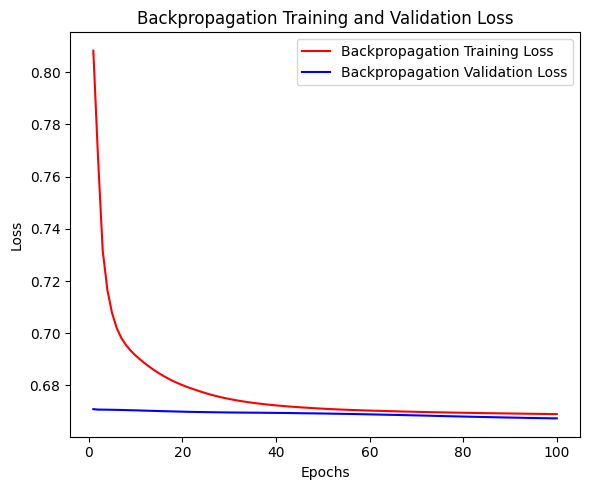

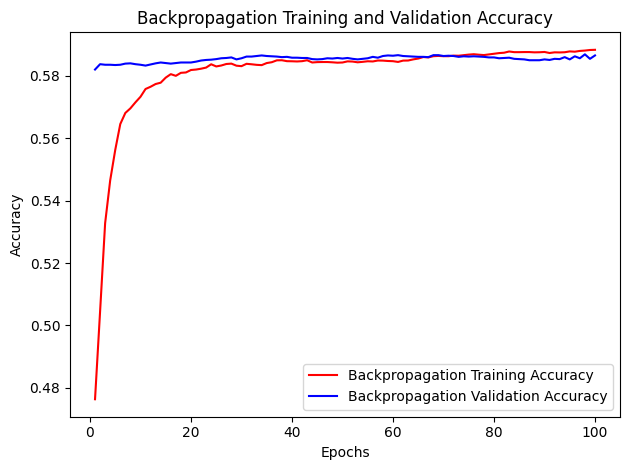

In [29]:
#  training loss and accuracy values for each epoch
epochs = range(1, len(backprop_training_losses) + 1)

# Ensure that bnn_val_loss has the same length as epochs
backprop_val_loss_plot = backprop_val_loss[:len(epochs)]

plt.figure(figsize=(6, 5))

# Plot Backpropagation
plt.plot(epochs, backprop_training_losses, 'r', label='Backpropagation Training Loss')
plt.plot(epochs, backprop_val_loss, 'b', label='Backpropagation Validation Loss')
plt.title('Backpropagation Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


plt.plot(epochs, backprop_training_accuracies, 'r', label='Backpropagation Training Accuracy')
plt.plot(epochs, backprop_val_accuracy, 'b', label='Backpropagation Validation Accuracy')
plt.title('Backpropagation Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Learning Curve for BNN 

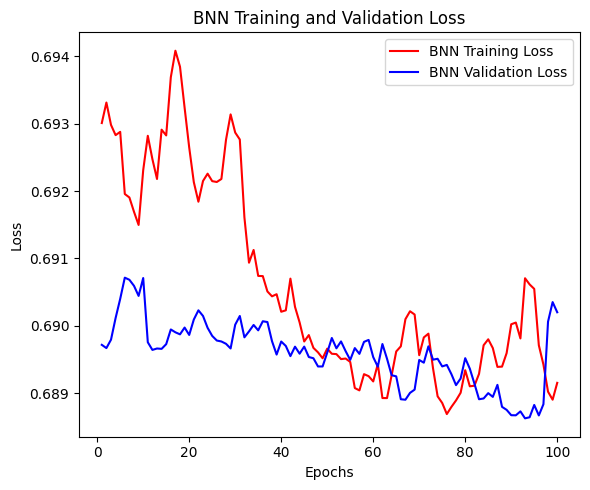

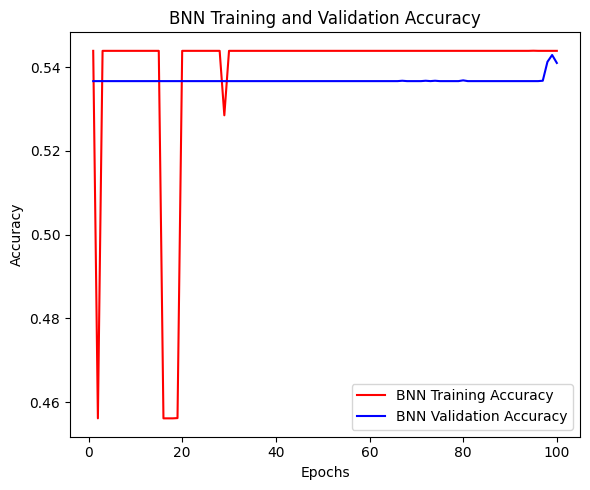

In [28]:
#  training loss and accuracy values for each epoch
epochs = range(1, len(bnn_training_losses) + 1)

# Ensure that bnn_val_loss has the same length as epochs
bnn_val_loss_plot = bnn_val_loss[:len(epochs)]

plt.figure(figsize=(6, 5))

# Plot BNN
plt.plot(epochs, bnn_training_losses, 'r', label='BNN Training Loss')
plt.plot(epochs, bnn_val_loss, 'b', label='BNN Validation Loss')
plt.title('BNN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
plt.plot(epochs, bnn_training_accuracies, 'r', label='BNN Training Accuracy')
plt.plot(epochs, bnn_val_accuracy, 'b', label='BNN Validation Accuracy')
plt.title('BNN Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Learning Curve for RProp

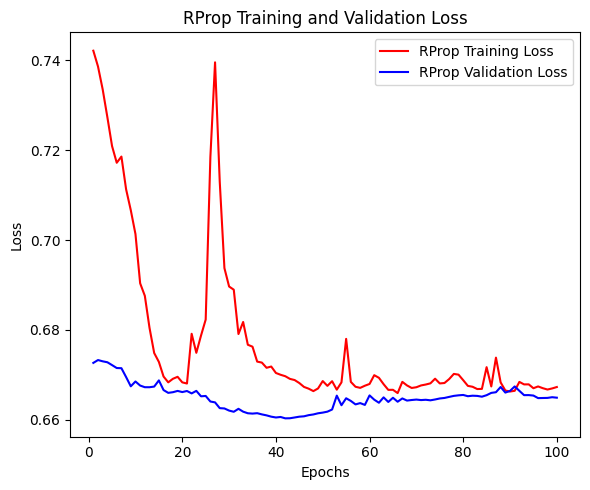

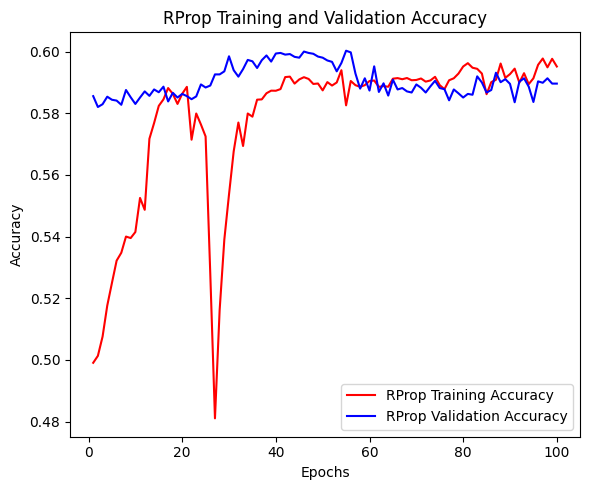

In [22]:
# training loss and accuracy values for each epoch
epochs = range(1, len(rprop_training_losses) + 1)

plt.figure(figsize=(6, 5))

# Plot RProp
plt.plot(epochs, rprop_training_losses, 'r', label='RProp Training Loss')
plt.plot(epochs, rprop_val_loss, 'b', label='RProp Validation Loss')
plt.title('RProp Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
plt.plot(epochs, rprop_training_accuracies, 'r', label='RProp Training Accuracy')
plt.plot(epochs, rprop_val_accuracy, 'b', label='RProp Validation Accuracy')
plt.title('RProp Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

#  Compare BNN and Rprop Learning Curves

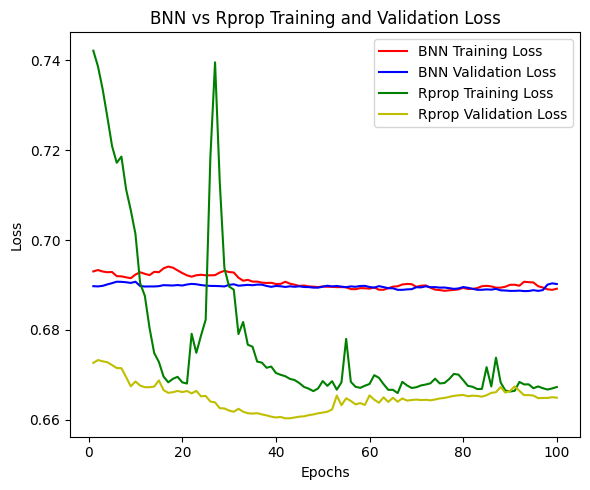

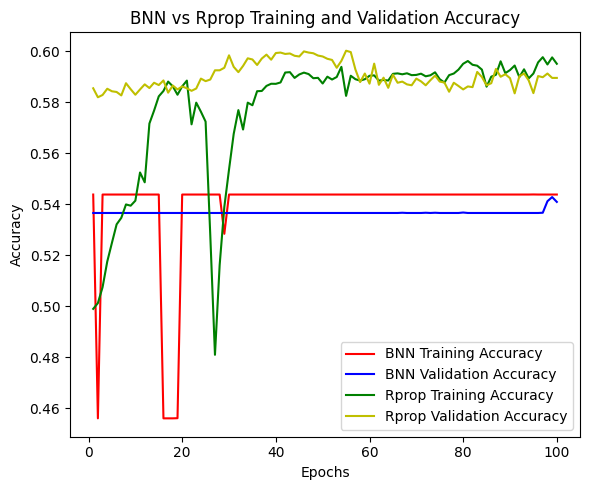

In [30]:
# Loss comparison
plt.figure(figsize=(6, 5))
plt.plot(epochs, bnn_training_losses, 'r', label='BNN Training Loss')
plt.plot(epochs, bnn_val_loss, 'b', label='BNN Validation Loss')
plt.plot(epochs, rprop_training_losses, 'g', label='Rprop Training Loss')
plt.plot(epochs, rprop_val_loss, 'y', label='Rprop Validation Loss')
plt.title('BNN vs Rprop Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Accuracy comparison
plt.figure(figsize=(6, 5))
plt.plot(epochs, bnn_training_accuracies, 'r', label='BNN Training Accuracy')
plt.plot(epochs, bnn_val_accuracy, 'b', label='BNN Validation Accuracy')
plt.plot(epochs, rprop_training_accuracies, 'g', label='Rprop Training Accuracy')
plt.plot(epochs, rprop_val_accuracy, 'y', label='Rprop Validation Accuracy')
plt.title('BNN vs Rprop Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# RProp Confusion Matrix


Rprop Metrics:
Precision: 0.5590
Recall: 0.4272
F1-score: 0.4843


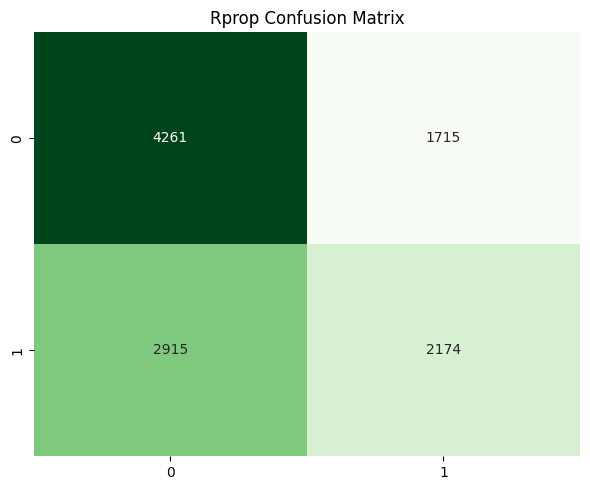

In [24]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns


# Assuming your 'evaluate' method returns loss, accuracy, and predictions
rprop_loss, rprop_accuracy, rprop_predictions =rprop_nn.evaluate(x_test,y_test.reshape(-1,1))

# Threshold predictions for binary classification
binary_rprop_predictions = (rprop_predictions >= 0.5).astype(int)

# Calculate confusion matrix for Rprop
rprop_conf_matrix = confusion_matrix(y_test, binary_rprop_predictions)

# Calculate Precision, Recall, and F1-score for Rprop
rprop_precision = precision_score(y_test, binary_rprop_predictions)
rprop_recall = recall_score(y_test, binary_rprop_predictions)
rprop_f1 = f1_score(y_test, binary_rprop_predictions)

# Print the results for Rprop
print("\nRprop Metrics:")
print(f'Precision: {rprop_precision:.4f}')
print(f'Recall: {rprop_recall:.4f}')
print(f'F1-score: {rprop_f1:.4f}')

# Plot confusion matrix for Rprop
plt.figure(figsize=(6, 5))
sns.heatmap(rprop_conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Rprop Confusion Matrix')
plt.tight_layout()
plt.show()


# BNN Confusion Matrix

BNN Metrics:
Precision: 0.4599
Recall: 1.0000
F1-score: 0.6301


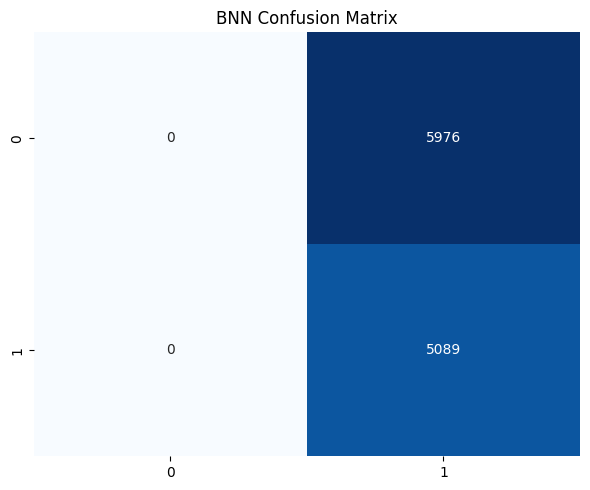

In [25]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns


# Assuming your 'evaluate' method returns loss, accuracy, and predictions
bnn_loss, bnn_accuracy, bnn_predictions = bnn.evaluate(x_test, y_test.reshape(-1, 1))

# Threshold predictions for binary classification
binary_bnn_predictions = (bnn_predictions >= 0.5).astype(int)

# Calculate confusion matrix for BNN
bnn_conf_matrix = confusion_matrix(y_test, binary_bnn_predictions)

# Calculate Precision, Recall, and F1-score for BNN
bnn_precision = precision_score(y_test, binary_bnn_predictions)
bnn_recall = recall_score(y_test, binary_bnn_predictions)
bnn_f1 = f1_score(y_test, binary_bnn_predictions)

# Print the results for BNN
print("BNN Metrics:")
print(f'Precision: {bnn_precision:.4f}')
print(f'Recall: {bnn_recall:.4f}')
print(f'F1-score: {bnn_f1:.4f}')

# Plot confusion matrix for BNN
plt.figure(figsize=(6, 5))
sns.heatmap(bnn_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('BNN Confusion Matrix')
plt.tight_layout()
plt.show()


# Backpropagation Confusion Matrix

#  ROC Curves

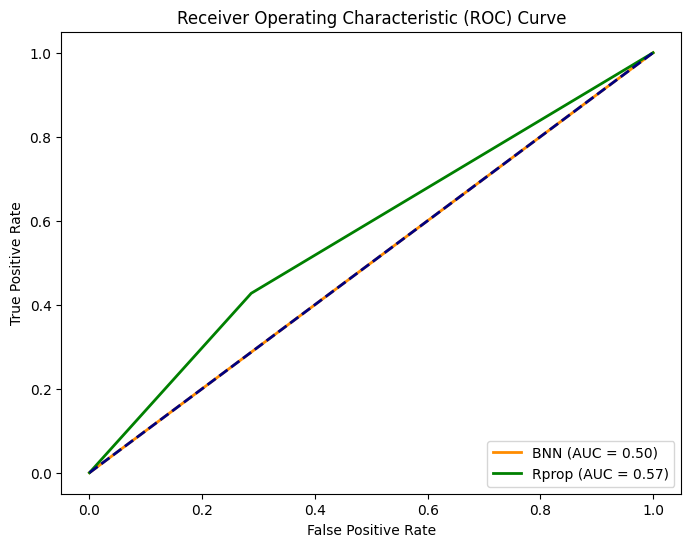

In [26]:
from sklearn.metrics import roc_curve, auc

# binary classification with labels and predicted probabilities for both BNN and Rprop models
fpr_bnn, tpr_bnn, _ = roc_curve(y_test, binary_bnn_predictions)
roc_auc_bnn = auc(fpr_bnn, tpr_bnn)

fpr_rprop, tpr_rprop, _ = roc_curve(y_test, binary_rprop_predictions)
roc_auc_rprop = auc(fpr_rprop, tpr_rprop)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_bnn, tpr_bnn, color='darkorange', lw=2, label='BNN (AUC = %0.2f)' % roc_auc_bnn)
plt.plot(fpr_rprop, tpr_rprop, color='green', lw=2, label='Rprop (AUC = %0.2f)' % roc_auc_rprop)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()